In [1]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import seaborn as sns
import datetime
import ssl
import joblib

In [2]:
# The maximum timeframe from which we can exract data is from 2011 to 2021. 
# We will use this available data to train our models
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

current_year = datetime.datetime.now().year
base = 'https://www.americashealthrankings.org/api/v1/downloads/'
start = input('Enter Start year (2011-20xx): ')
end = input('Enter End year (2011-20xx): ')
frames = []
for year in range(int(start), int(end)+1):
    # Data before and after 2015 is on different end points hence adding a check
    if year >= 2015:
        # Getting report Id from page
        res = requests.get(f'https://www.americashealthrankings.org/explore/annual/measure/Suicide/state/ALL?edition-year={year}')
    # Faced issues when scraping page for different years, figured out a way to get report ID
        source_id = res.text.split(f'"Name":"{year} Annual","EditionId":')[1][:4]
        # Checking if edition ID is 2,3 or 4 digits
        if source_id.isdecimal():
            df = pd.read_csv(base + source_id)
        elif source_id[:3].isdecimal():
            df = pd.read_csv(base + source_id[:3])
        else:
            df = pd.read_csv(base + source_id[:2])
    else:
        df = pd.read_csv(base + f'report/1/{year}')
    
    # Filtering only suicide data
    df['Measure Name'] = df['Measure Name'].fillna('Blank')
    df_2 = df[df['Measure Name'].str.contains('Suicide')]
    # Adding to dataframes list
    frames.append(df_2)

Enter Start year (2011-20xx): 2011
Enter End year (2011-20xx): 2021


In [3]:
# Merging all yearly data into a single dataframe    
df = pd.concat(frames)
# selecting necessary columns only
df = df[['Edition', 'Measure Name', 'Value', 'State Name']]
df.head()

,Edition,Measure Name,Value,State Name
11856,2011,Suicide,14.1,Alabama
11857,2011,Suicide,20.4,Alaska
11858,2011,Suicide,17.1,Arizona
11859,2011,Suicide,14.7,Arkansas
11860,2011,Suicide,10.7,California


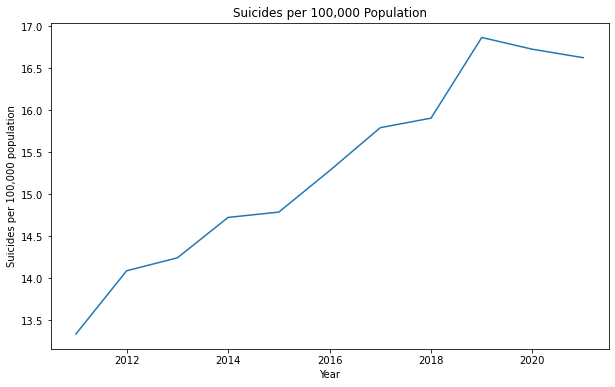

In [4]:
"""Date for each parameter is contained in a single CSV file as separate rows, below we will extract data for each parameter in a separate dataframe and plot it"""
# Extracting aggregated suicide data
df_total = df[df['Measure Name'] == 'Suicide']
# Grouping by year and ploting average suicide rate
total_data = df_total.groupby('Edition')['Value'].mean()
total_data.plot(figsize=(10,6), xlabel= 'Year', title = 'Suicides per 100,000 Population', ylabel = 'Suicides per 100,000 population')
plt.show()

In [5]:
total_data.index

Int64Index([2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021], dtype='int64', name='Edition')

In [6]:
total_data

Edition
2011    13.338462
2012    14.090385
2013    14.244231
2014    14.725000
2015    14.788462
2016    15.280769
2017    15.792308
2018    15.905769
2019    16.865385
2020    16.725000
2021    16.625000
Name: Value, dtype: float64

### Suicides per 100,000 prediction model

In [7]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose

In [8]:
#We are using a time series model, so lets initialize some dates
from datetime import date, timedelta
dt = pd.date_range(start='1/1/2022', end='1/17/2022')
len(dt)

17

In [9]:
total_data_df = pd.DataFrame()
total_data_df['my_date'] = dt
#total_data_df['other'] = range(0,14)
my_data = []
for i in range(0,11):
    value = total_data.iloc[i]
    my_data.append(value)
n5 = my_data[0]*0.9
n4 = n5*0.9
n3 = n4*0.9
n3 = n4*0.9
n2 = n3*0.9
n1 = n2*0.9
n0 = n1*0.9
li = [n0,n1,n2,n3,n4,n5]
final_list = li+my_data
print(len(final_list))
total_data_df['x'] = final_list
total_data_df.head()

17


,my_date,x
0,2022-01-01,7.088605
1,2022-01-02,7.876228
2,2022-01-03,8.751365
3,2022-01-04,9.723738
4,2022-01-05,10.804154


In [10]:
total_data_df.index = total_data_df['my_date']
total_data_df

,my_date,x
my_date,,
2022-01-01,2022-01-01,7.088605
2022-01-02,2022-01-02,7.876228
2022-01-03,2022-01-03,8.751365
2022-01-04,2022-01-04,9.723738
2022-01-05,2022-01-05,10.804154
2022-01-06,2022-01-06,12.004615
2022-01-07,2022-01-07,13.338462
2022-01-08,2022-01-08,14.090385
2022-01-09,2022-01-09,14.244231


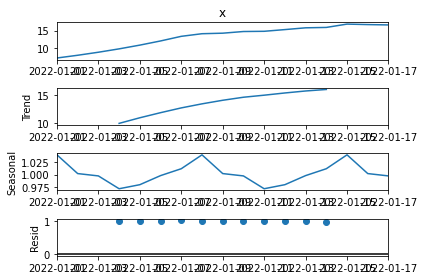

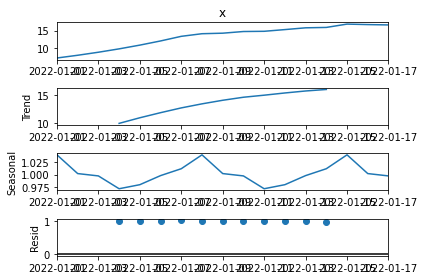

In [11]:
result_a = seasonal_decompose(total_data_df['x'], model = 'multiplicative')
result_a.plot()

In [12]:
model = SARIMAX(total_data_df['x'], order = (5,1,3), seasonal_order = (1,1,1,12))

C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [13]:
model_fit = model.fit()

C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [14]:
residuals = model_fit.resid
residuals

my_date
2022-01-01    7.088605
2022-01-02    0.787622
2022-01-03    0.875136
2022-01-04    0.972372
2022-01-05    1.080413
2022-01-06    1.200460
2022-01-07    1.333843
2022-01-08    0.751919
2022-01-09    0.153843
2022-01-10    0.480766
2022-01-11    0.063457
2022-01-12    0.492304
2022-01-13   -3.032770
2022-01-14   -0.674163
2022-01-15    0.399070
2022-01-16   -1.130872
2022-01-17   -0.000041
dtype: float64

<AxesSubplot:xlabel='my_date'>

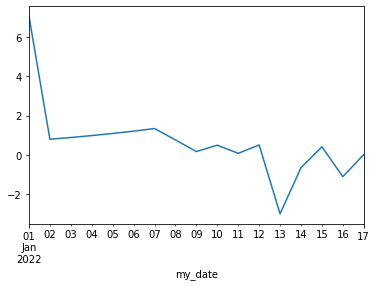

In [15]:
residuals.plot()

In [16]:
output = model_fit.forecast()
output

2022-01-18    17.881275
Freq: D, dtype: float64

In [17]:
yhat = model_fit.predict()
yhat

2022-01-01     0.000000
2022-01-02     7.088606
2022-01-03     7.876229
2022-01-04     8.751367
2022-01-05     9.723741
2022-01-06    10.804155
2022-01-07    12.004618
2022-01-08    13.338465
2022-01-09    14.090388
2022-01-10    14.244234
2022-01-11    14.725005
2022-01-12    14.788465
2022-01-13    18.825078
2022-01-14    16.579932
2022-01-15    16.466314
2022-01-16    17.855872
2022-01-17    16.625041
Freq: D, Name: predicted_mean, dtype: float64

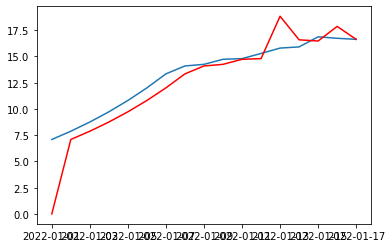

In [18]:
plt.plot(total_data_df['x'])
plt.plot(yhat, color = 'red')

In [19]:
## R2 Score
from sklearn.metrics import mean_squared_error, r2_score
r2_score(total_data_df['x'].values, yhat)

0.5871828181619477

In [20]:
model_fit.forecast(5)

2022-01-18    17.881275
2022-01-19    18.625178
2022-01-20    17.923656
2022-01-21    17.768084
2022-01-22    18.142694
Freq: D, Name: predicted_mean, dtype: float64

In [21]:
#Lets now save the model
joblib.dump(model_fit, "./models/Suicides_per_100K.joblib")

['./models/Suicides_per_100K.joblib']

## Suicide data for ages 15-24 prediction model

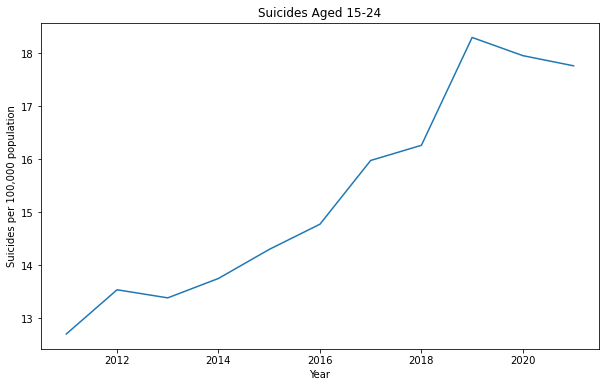

In [22]:
# Extracting suicide data for ages 15-24
df_total = df[df['Measure Name'] == 'Suicide - Ages 15-24']
total_data = df_total.groupby('Edition')['Value'].mean()
total_data.plot(figsize=(10,6), xlabel= 'Year', title = 'Suicides Aged 15-24', ylabel = 'Suicides per 100,000 population')
plt.show()

In [23]:
total_data

Edition
2011    12.706522
2012    13.539583
2013    13.386957
2014    13.753191
2015    14.300000
2016    14.775000
2017    15.976087
2018    16.261702
2019    18.293750
2020    17.951020
2021    17.759574
Name: Value, dtype: float64

In [24]:
total_data_df = pd.DataFrame()
total_data_df['my_date'] = dt
#total_data_df['other'] = range(0,14)
my_data = []
for i in range(0,11):
    value = total_data.iloc[i]
    my_data.append(value)
n5 = my_data[0]*0.9
n4 = n5*0.9
n3 = n4*0.9
n3 = n4*0.9
n2 = n3*0.9
n1 = n2*0.9
n0 = n1*0.9
li = [n0,n1,n2,n3,n4,n5]
final_list = li+my_data
print(len(final_list))
total_data_df['x'] = final_list
total_data_df.head()

17


,my_date,x
0,2022-01-01,6.752767
1,2022-01-02,7.503074
2,2022-01-03,8.336749
3,2022-01-04,9.263054
4,2022-01-05,10.292283


In [25]:
total_data_df.index = total_data_df['my_date']
total_data_df.head()

,my_date,x
my_date,,
2022-01-01,2022-01-01,6.752767
2022-01-02,2022-01-02,7.503074
2022-01-03,2022-01-03,8.336749
2022-01-04,2022-01-04,9.263054
2022-01-05,2022-01-05,10.292283


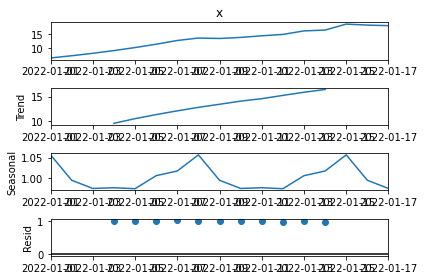

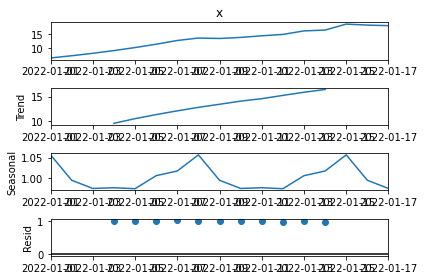

In [26]:
result_a = seasonal_decompose(total_data_df['x'], model = 'multiplicative')
result_a.plot()

In [27]:
model = SARIMAX(total_data_df['x'], order = (5,1,3), seasonal_order = (1,1,1,12))

C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [28]:
model_fit = model.fit()

C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<AxesSubplot:xlabel='my_date'>

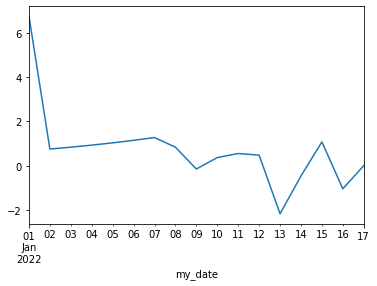

In [29]:
residuals = model_fit.resid
residuals.plot()

In [30]:
yhat = model_fit.predict()
yhat

2022-01-01     0.000000
2022-01-02     6.752765
2022-01-03     7.503071
2022-01-04     8.336752
2022-01-05     9.263055
2022-01-06    10.292279
2022-01-07    11.435871
2022-01-08    12.706524
2022-01-09    13.539580
2022-01-10    13.386957
2022-01-11    13.753196
2022-01-12    14.299997
2022-01-13    18.151384
2022-01-14    16.726398
2022-01-15    17.223972
2022-01-16    18.995723
2022-01-17    17.760166
Freq: D, Name: predicted_mean, dtype: float64

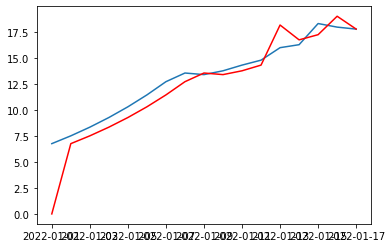

In [31]:
plt.plot(total_data_df['x'])
plt.plot(yhat, color = 'red')

In [32]:
r2_score(total_data_df['x'].values, yhat)

0.7200673104497206

In [33]:
model_fit.forecast(5)

2022-01-18    20.117066
2022-01-19    20.866015
2022-01-20    19.949190
2022-01-21    20.637410
2022-01-22    21.279290
Freq: D, Name: predicted_mean, dtype: float64

In [34]:
#model_fit.save("Suicides_for_ages_15_24.h5")
#Lets now save the model
joblib.dump(model_fit, "./models/Suicides_for_ages_15_24.joblib")

['./models/Suicides_for_ages_15_24.joblib']

## Gender based Suicide data models

### i. Male

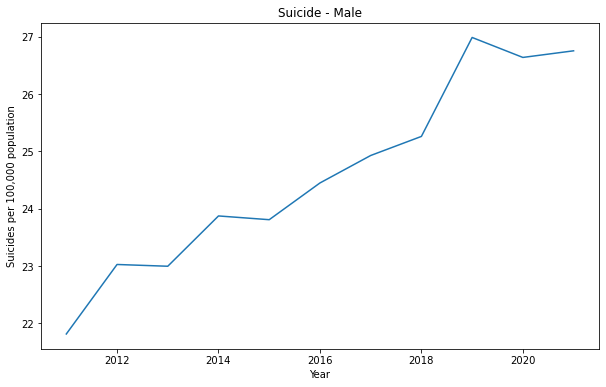

17


C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  

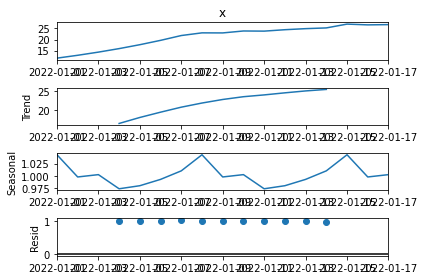

In [35]:
#This is the procedure for creating the models above
# Extracting suicide data for males
group = 'Suicide - Male'
df_total = df[df['Measure Name'] == group]
total_data = df_total.groupby('Edition')['Value'].mean()
total_data.plot(figsize=(10,6), xlabel= 'Year', title = group, ylabel = 'Suicides per 100,000 population')
plt.show()
total_data_df = pd.DataFrame()
total_data_df['my_date'] = dt
#total_data_df['other'] = range(0,14)
my_data = []
for i in range(0,11):
    value = total_data.iloc[i]
    my_data.append(value)
n5 = my_data[0]*0.9
n4 = n5*0.9
n3 = n4*0.9
n3 = n4*0.9
n2 = n3*0.9
n1 = n2*0.9
n0 = n1*0.9
li = [n0,n1,n2,n3,n4,n5]
final_list = li+my_data
print(len(final_list))
total_data_df['x'] = final_list
#total_data_df.head()
total_data_df.index = total_data_df['my_date']
result_a = seasonal_decompose(total_data_df['x'], model = 'multiplicative')
result_a.plot()
model = SARIMAX(total_data_df['x'], order = (5,1,3), seasonal_order = (1,1,1,12))
model_fit = model.fit()

<AxesSubplot:xlabel='my_date'>

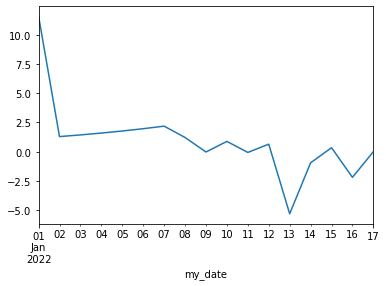

In [36]:
residuals = model_fit.resid
residuals.plot()

In [37]:
yhat = model_fit.predict()
yhat

2022-01-01     0.000000
2022-01-02    11.593590
2022-01-03    12.881764
2022-01-04    14.313081
2022-01-05    15.903420
2022-01-06    17.670460
2022-01-07    19.633853
2022-01-08    21.815394
2022-01-09    23.026925
2022-01-10    22.996161
2022-01-11    23.873090
2022-01-12    23.807695
2022-01-13    30.244884
2022-01-14    26.215105
2022-01-15    26.646593
2022-01-16    28.834468
2022-01-17    26.751914
Freq: D, Name: predicted_mean, dtype: float64

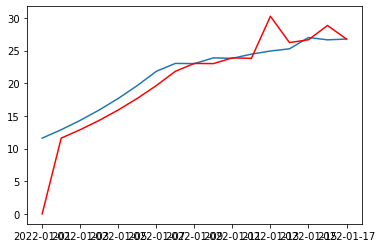

In [38]:
plt.plot(total_data_df['x'])
plt.plot(yhat, color = 'red')

In [39]:
r2_score(total_data_df['x'].values, yhat)

0.535485437606037

In [40]:
model_fit.forecast(5)

2022-01-18    29.098417
2022-01-19    29.976213
2022-01-20    29.009957
2022-01-21    29.089653
2022-01-22    29.376568
Freq: D, Name: predicted_mean, dtype: float64

In [41]:
#model_fit.save("Suicides_gender_male.h5")

joblib.dump(model_fit, "./models/Suicides_gender_male.joblib")

['./models/Suicides_gender_male.joblib']

### ii. Female

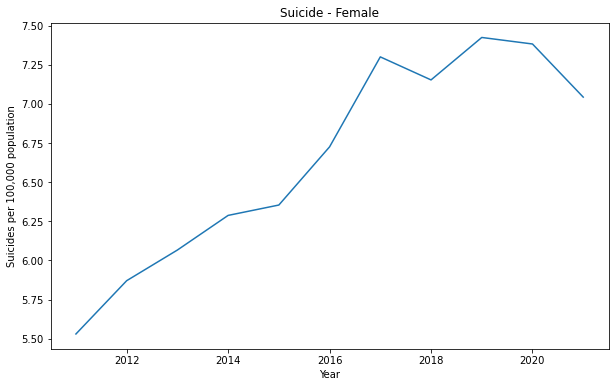

17


C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  

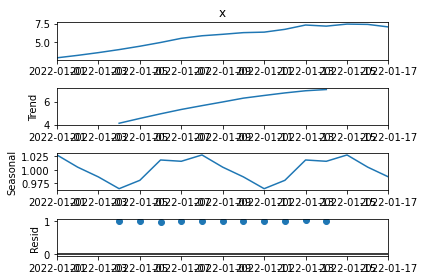

In [42]:
# Extracting suicide data for females
group = 'Suicide - Female'
df_total = df[df['Measure Name'] == group]
total_data = df_total.groupby('Edition')['Value'].mean()
total_data.plot(figsize=(10,6), xlabel= 'Year', title = group, ylabel = 'Suicides per 100,000 population')
plt.show()
total_data_df = pd.DataFrame()
total_data_df['my_date'] = dt
#total_data_df['other'] = range(0,14)
my_data = []
for i in range(0,11):
    value = total_data.iloc[i]
    my_data.append(value)
n5 = my_data[0]*0.9
n4 = n5*0.9
n3 = n4*0.9
n3 = n4*0.9
n2 = n3*0.9
n1 = n2*0.9
n0 = n1*0.9
li = [n0,n1,n2,n3,n4,n5]
final_list = li+my_data
print(len(final_list))
total_data_df['x'] = final_list
#total_data_df.head()
total_data_df.index = total_data_df['my_date']
result_a = seasonal_decompose(total_data_df['x'], model = 'multiplicative')
result_a.plot()
model = SARIMAX(total_data_df['x'], order = (5,1,3), seasonal_order = (1,1,1,12))
model_fit = model.fit()
#residuals = model_fit.resid
#residuals.plot()

In [43]:
yhat = model_fit.predict()
#yhat

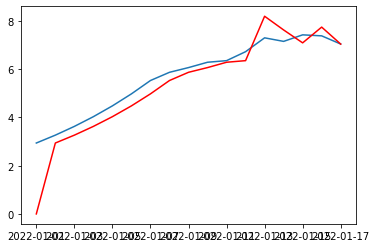

In [44]:
plt.plot(total_data_df['x'])
plt.plot(yhat, color = 'red')

In [45]:
print('r2_score:', r2_score(total_data_df['x'].values, yhat))
model_fit.forecast(5)

r2_score: 0.6910008263032246


2022-01-18    7.141483
2022-01-19    7.596598
2022-01-20    7.420100
2022-01-21    6.841636
2022-01-22    6.734379
Freq: D, Name: predicted_mean, dtype: float64

In [46]:
#model_fit.save("Suicides_gender_female.h5")

joblib.dump(model_fit, "./models/Suicides_gender_female.joblib")

['./models/Suicides_gender_female.joblib']

## Racial suicide data predictive models

### i. Suicide - American Indian/Alaska Native

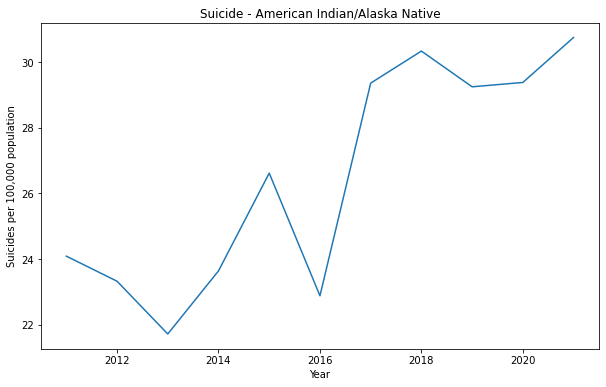

17


C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  

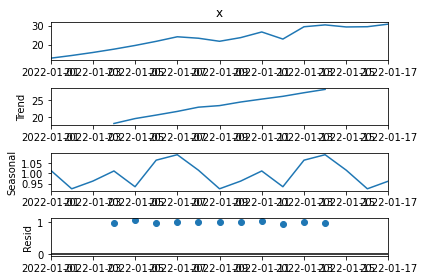

In [47]:
# Extracting suicide data for American Indian/Alaska Native
group = 'Suicide - American Indian/Alaska Native'
df_total = df[df['Measure Name'] == group]
total_data = df_total.groupby('Edition')['Value'].mean()
total_data.plot(figsize=(10,6), xlabel= 'Year', title = group, ylabel = 'Suicides per 100,000 population')
plt.show()
total_data_df = pd.DataFrame()
total_data_df['my_date'] = dt
#total_data_df['other'] = range(0,14)
my_data = []
for i in range(0,11):
    value = total_data.iloc[i]
    my_data.append(value)
n5 = my_data[0]*0.9
n4 = n5*0.9
n3 = n4*0.9
n3 = n4*0.9
n2 = n3*0.9
n1 = n2*0.9
n0 = n1*0.9
li = [n0,n1,n2,n3,n4,n5]
final_list = li+my_data
print(len(final_list))
total_data_df['x'] = final_list
#total_data_df.head()
total_data_df.index = total_data_df['my_date']
result_a = seasonal_decompose(total_data_df['x'], model = 'multiplicative')
result_a.plot()
model = SARIMAX(total_data_df['x'], order = (5,1,3), seasonal_order = (1,1,1,12))
model_fit = model.fit()
#residuals = model_fit.resid
#residuals.plot()

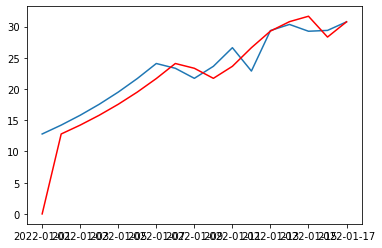

In [48]:
yhat = model_fit.predict()
#yhat
plt.plot(total_data_df['x'])
plt.plot(yhat, color = 'red')

In [49]:
print('r2_score:', r2_score(total_data_df['x'].values, yhat))
model_fit.forecast(5)

r2_score: 0.5776374335098675


2022-01-18    35.072192
2022-01-19    39.481701
2022-01-20    40.273514
2022-01-21    37.377506
2022-01-22    37.352084
Freq: D, Name: predicted_mean, dtype: float64

In [50]:
#model_fit.save("Suicides_race_American Indian_Alaska Native.h5")

joblib.dump(model_fit, "./models/Suicides_race_American Indian_Alaska Native.joblib")

['./models/Suicides_race_American Indian_Alaska Native.joblib']

### ii. Asian/Pacific Islander

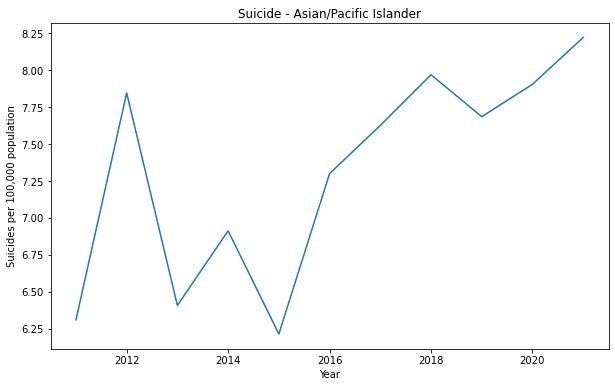

17


C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  

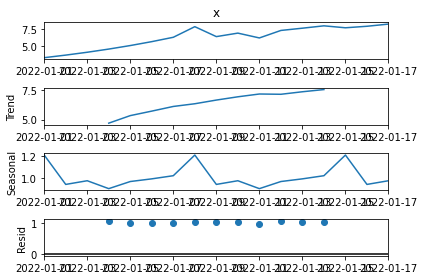

In [51]:
# Extracting suicide data for Asian/Pacific Islander
group = 'Suicide - Asian/Pacific Islander'
df_total = df[df['Measure Name'] == group]
total_data = df_total.groupby('Edition')['Value'].mean()
total_data.plot(figsize=(10,6), xlabel= 'Year', title = group, ylabel = 'Suicides per 100,000 population')
plt.show()
total_data_df = pd.DataFrame()
total_data_df['my_date'] = dt
#total_data_df['other'] = range(0,14)
my_data = []
for i in range(0,11):
    value = total_data.iloc[i]
    my_data.append(value)
n5 = my_data[0]*0.9
n4 = n5*0.9
n3 = n4*0.9
n3 = n4*0.9
n2 = n3*0.9
n1 = n2*0.9
n0 = n1*0.9
li = [n0,n1,n2,n3,n4,n5]
final_list = li+my_data
print(len(final_list))
total_data_df['x'] = final_list
#total_data_df.head()
total_data_df.index = total_data_df['my_date']
result_a = seasonal_decompose(total_data_df['x'], model = 'multiplicative')
result_a.plot()
model = SARIMAX(total_data_df['x'], order = (5,1,3), seasonal_order = (1,1,1,12))
model_fit = model.fit()
#residuals = model_fit.resid
#residuals.plot()

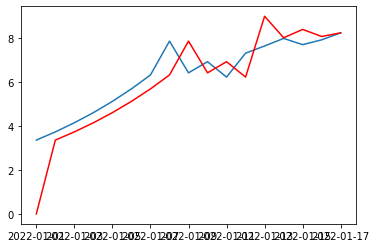

In [52]:
yhat = model_fit.predict()
#yhat
plt.plot(total_data_df['x'])
plt.plot(yhat, color = 'red')

In [53]:
print('r2_score:', r2_score(total_data_df['x'].values, yhat))
model_fit.forecast(5)

r2_score: 0.47982118617814074


2022-01-18    8.075975
2022-01-19    8.654367
2022-01-20    9.759079
2022-01-21    7.742025
2022-01-22    8.247630
Freq: D, Name: predicted_mean, dtype: float64

In [54]:
#model_fit.save("Suicides_race_Asian_Pacific Islander.h5")

joblib.dump(model_fit, "./models/Suicides_race_Asian_Pacific Islander.joblib")

['./models/Suicides_race_Asian_Pacific Islander.joblib']

### iii. Black

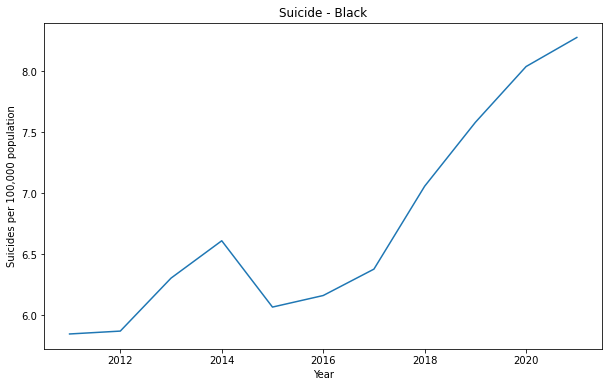

17


C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  

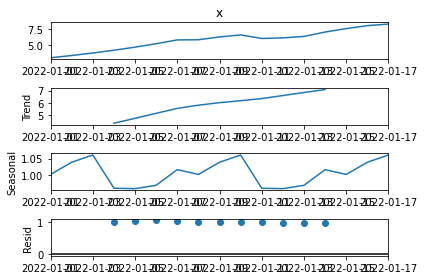

In [55]:
# Extracting suicide data for the black
group = 'Suicide - Black'
df_total = df[df['Measure Name'] == group]
total_data = df_total.groupby('Edition')['Value'].mean()
total_data.plot(figsize=(10,6), xlabel= 'Year', title = group, ylabel = 'Suicides per 100,000 population')
plt.show()
total_data_df = pd.DataFrame()
total_data_df['my_date'] = dt
#total_data_df['other'] = range(0,14)
my_data = []
for i in range(0,11):
    value = total_data.iloc[i]
    my_data.append(value)
n5 = my_data[0]*0.9
n4 = n5*0.9
n3 = n4*0.9
n3 = n4*0.9
n2 = n3*0.9
n1 = n2*0.9
n0 = n1*0.9
li = [n0,n1,n2,n3,n4,n5]
final_list = li+my_data
print(len(final_list))
total_data_df['x'] = final_list
#total_data_df.head()
total_data_df.index = total_data_df['my_date']
result_a = seasonal_decompose(total_data_df['x'], model = 'multiplicative')
result_a.plot()
model = SARIMAX(total_data_df['x'], order = (5,1,3), seasonal_order = (1,1,1,12))
model_fit = model.fit()
#residuals = model_fit.resid
#residuals.plot()

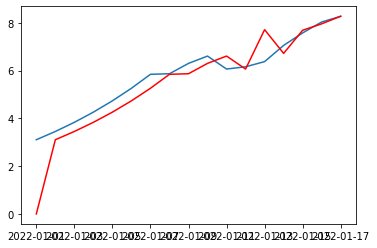

In [56]:
yhat = model_fit.predict()
#yhat
plt.plot(total_data_df['x'])
plt.plot(yhat, color = 'red')

In [57]:
print('r2_score:', r2_score(total_data_df['x'].values, yhat))
model_fit.forecast(5)

r2_score: 0.6435127960857171


2022-01-18    8.540648
2022-01-19    8.803082
2022-01-20    8.718866
2022-01-21    9.160874
2022-01-22    9.728006
Freq: D, Name: predicted_mean, dtype: float64

In [58]:
#model_fit.save("Suicides_race_black.h5")

joblib.dump(model_fit, "./models/Suicides_race_black.joblib")

['./models/Suicides_race_black.joblib']

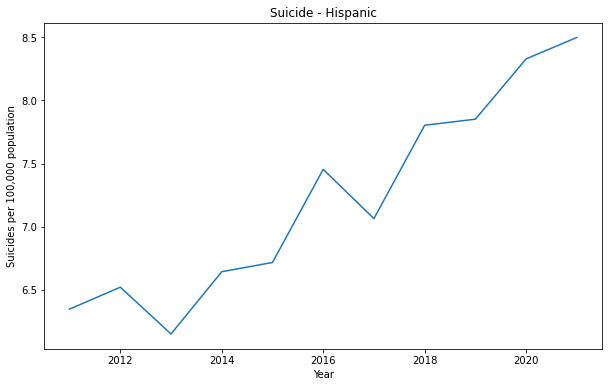

17


C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  

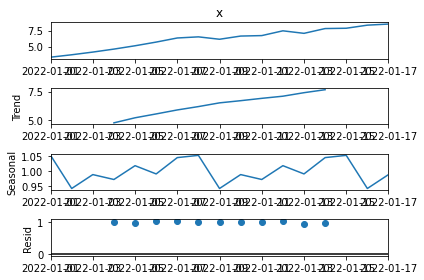

In [59]:
# Extracting suicide data for the Hispanic
group = 'Suicide - Hispanic'
df_total = df[df['Measure Name'] == group]
total_data = df_total.groupby('Edition')['Value'].mean()
total_data.plot(figsize=(10,6), xlabel= 'Year', title = group, ylabel = 'Suicides per 100,000 population')
plt.show()
total_data_df = pd.DataFrame()
total_data_df['my_date'] = dt
#total_data_df['other'] = range(0,14)
my_data = []
for i in range(0,11):
    value = total_data.iloc[i]
    my_data.append(value)
n5 = my_data[0]*0.9
n4 = n5*0.9
n3 = n4*0.9
n3 = n4*0.9
n2 = n3*0.9
n1 = n2*0.9
n0 = n1*0.9
li = [n0,n1,n2,n3,n4,n5]
final_list = li+my_data
print(len(final_list))
total_data_df['x'] = final_list
#total_data_df.head()
total_data_df.index = total_data_df['my_date']
result_a = seasonal_decompose(total_data_df['x'], model = 'multiplicative')
result_a.plot()
model = SARIMAX(total_data_df['x'], order = (5,1,3), seasonal_order = (1,1,1,12))
model_fit = model.fit()
#residuals = model_fit.resid
#residuals.plot()

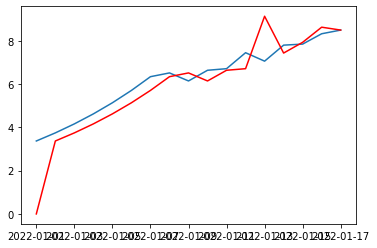

In [60]:
yhat = model_fit.predict()
#yhat
plt.plot(total_data_df['x'])
plt.plot(yhat, color = 'red')

In [61]:
print('r2_score:', r2_score(total_data_df['x'].values, yhat))
model_fit.forecast(5)

r2_score: 0.5401118930067541


2022-01-18     9.459468
2022-01-19    10.075271
2022-01-20    10.569985
2022-01-21     9.791519
2022-01-22    10.309737
Freq: D, Name: predicted_mean, dtype: float64

In [62]:
#model_fit.save("Suicides_race_Hispanic.h5")

joblib.dump(model_fit, "./models/Suicides_race_Hispanic.joblib")

['./models/Suicides_race_Hispanic.joblib']

In [63]:
#Loop the  Age based suicide data!
Measure_Names = ['Suicide - Ages 15-24','Suicide - Ages 25-34','Suicide - Ages 35-44','Suicide - Ages 45-54',
                 'Suicide - Ages 55-64','Suicide - Ages 65-74','Suicide - Ages 75-84','Suicide - Ages 85+']
for i in range(0,len(Measure_Names)):
    # Extracting suicide data for the Hispanic
    group = Measure_Names[i]
    df_total = df[df['Measure Name'] == group]
    total_data = df_total.groupby('Edition')['Value'].mean()
    #total_data.plot(figsize=(10,6), xlabel= 'Year', title = group, ylabel = 'Suicides per 100,000 population')
    #plt.show()
    total_data_df = pd.DataFrame()
    total_data_df['my_date'] = dt
    #total_data_df['other'] = range(0,14)
    my_data = []
    for i in range(0,11):
        value = total_data.iloc[i]
        my_data.append(value)
    n5 = my_data[0]*0.9
    n4 = n5*0.9
    n3 = n4*0.9
    n3 = n4*0.9
    n2 = n3*0.9
    n1 = n2*0.9
    n0 = n1*0.9
    li = [n0,n1,n2,n3,n4,n5]
    final_list = li+my_data
    print(len(final_list))
    total_data_df['x'] = final_list
    #total_data_df.head()
    total_data_df.index = total_data_df['my_date']
    result_a = seasonal_decompose(total_data_df['x'], model = 'multiplicative')
    #result_a.plot()
    model = SARIMAX(total_data_df['x'], order = (5,1,3), seasonal_order = (1,1,1,12))
    model_fit = model.fit()
    #residuals = model_fit.resid
    #residuals.plot()
    yhat = model_fit.predict()
    print('r2_score:', r2_score(total_data_df['x'].values, yhat))
    #model_fit.save("Suicides_age_group{}.h5".format(group))
    joblib.dump(model_fit, "./models/Suicides_age_group{}.joblib".format(group))

17


C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  

r2_score: 0.7200673104497206
17


C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Pro

r2_score: 0.7096089559816109
17


C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Pro

r2_score: 0.49477608511259563
17


C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Pro

r2_score: 0.42590380692785446
17


C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Pro

r2_score: 0.5591138871079184
17
r2_score: 0.4652372333391158
17


C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  

r2_score: 0.44228529063199884
17
r2_score: 0.2761707054450696


C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
